TAKURA WEKWETE (STUDENT NO u21717215)
MASTERS MIT BIG DATA SCIENCE 

NOVEMBER 2022 (TAKURAWEKWETE@GMAIL.COM OR u21717215@tuks.co.za)

CODE FOR CHAPTER 7


In [3]:
# Load reinfocement learning libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import random
import scipy.stats as stats
import seaborn as sns
from IPython.core.debugger import set_trace

#Import Model Packages for reinforcement learning
from keras import layers, models, optimizers
from keras import backend as K
import tensorflow as tf
from collections import namedtuple, deque

In [2]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
tf.version.VERSION

'1.13.1'

In [59]:
#MODEL RECORD
#THIS IS MODEL 9

TRADITIONAL SOLUTION BASED ON ANALYTICAL APPROACH

In [5]:
#The function below does immunisation by solving 2 simultaneous equations 1)PV(Assets)=PV(Liabilities) and 2) Duration(Assets)=Duration(Liabilities)
def zc_immuniser(m1,m2,liab_duration):  #m1=maturity for zero coupon bond 1 and m2 for zero coupon bond 2
    A=[[1,1],[m1,m2]]
    B=[1,liab_duration] 
    x=np.linalg.solve(A,B)
    #W1=x[0] #bond 1 allocation
    #print("Bond 1 allocation is",np.round(W1*100,2),"%")
    #W2=x[1] #bond 2 allocation 
    #print("Bond 2 allocation is",np.round(W2*100,2),"%")
    weight1_interim=x[0]
    weight2_interim=x[1]
    weight1=min(max(weight1_interim,0),1)
    weight2=min(max(weight2_interim,0),1)
    result=np.array([m1,m2,liab_duration,weight1,weight2])
    return result


FUNCTIONS WHICH GENERATE VARIOUS SIMULATIONS FOR A SPECIFIED NUMBER OF REQUIRED SIMULATIONS

In [6]:
def liability_duration_sim(steps,prob_increase,max_change,duration_start):
    
    duration_change_sign = np.random.choice(a=([1,-1]),p=([prob_increase,1-prob_increase]),size=steps)#increase or decrease 
    magnitude_of_duration_change =np.random.uniform(low=0,high=max_change,size=steps) 
    duration_change = duration_change_sign*magnitude_of_duration_change
    cumulative_duration_change=np.cumsum(duration_change)
    liab_duration_sim=duration_start+cumulative_duration_change

    return(liab_duration_sim)

In [7]:
def asset_term_sim(steps,change_sign,change_size,term_range_start,term_range_end):
    
    term_start = np.random.uniform(low=term_range_start,high=term_range_end,size=1) 
    change_sign_array = np.full((steps,),change_sign) 
    term_change = change_sign_array*change_size
    cumulative_term_change = np.cumsum(term_change)
    asset_term_sim = term_start+cumulative_term_change

    return(asset_term_sim)

In [8]:
def generate_one_simulation(steps,prob_increase,max_change,duration_start):
    one_liability_simulation=liability_duration_sim(steps,prob_increase,max_change,duration_start)
    one_asset1_simulation = asset_term_sim(steps,0,0,10,20)
    one_asset2_simulation = asset_term_sim(steps,0,0,30,40)
    one_simulation = np.stack((one_asset1_simulation,one_asset2_simulation,one_liability_simulation),axis=1)
    return(one_simulation)


In [9]:
def generate_multiple_simulations(steps,number_simulations,max_change=2,duration_start=25):

    first_simulation = generate_one_simulation(steps,0.5,max_change,duration_start)
    first_simulation_reshaped = np.reshape(first_simulation,(1,first_simulation.shape[0],first_simulation.shape[1]))
    multiple_simulations = first_simulation_reshaped
    
    for i in np.arange(start=1,stop=number_simulations):
        prob_inc=np.random.uniform(low=0.3,high=0.7)   #specifying the ranges of drift
        ith_simulation = generate_one_simulation(steps,prob_inc,max_change,duration_start)
        ith_simulation_reshaped = np.reshape(ith_simulation,(1,ith_simulation.shape[0],ith_simulation.shape[1]))
        multiple_simulations = np.concatenate((multiple_simulations,ith_simulation_reshaped),axis=0)
    
    multiple_simulations = np.transpose(multiple_simulations,axes=(1,0,2))
    return(multiple_simulations)

In [10]:
training_simulation=generate_multiple_simulations(steps=30,number_simulations=50000,max_change=2)
training_simulation.shape

(30, 50000, 3)

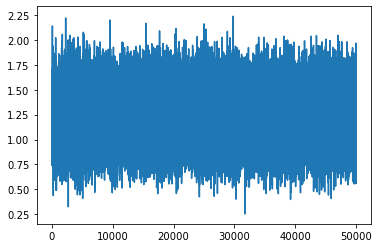

In [11]:
#Variance analysis 
variances=[]
for i in np.arange(training_simulation.shape[1]):
    vindex=i
    liability=training_simulation[:,vindex,2]
    liability_diff=np.diff(liability)
    var_index=np.var(liability_diff)
    variances=np.append(variances,var_index)
plt.plot(variances)

In [110]:

df_describe = pd.DataFrame(variances**2)
df_describe.describe()

,0
count,50000.000000
mean,1.582226
std,0.589569
min,0.091559
25%,1.157668
50%,1.524156
75%,1.941138
max,5.433540


In [74]:
training_simulation.shape

(30, 50000, 3)

<function matplotlib.pyplot.show(close=None, block=None)>

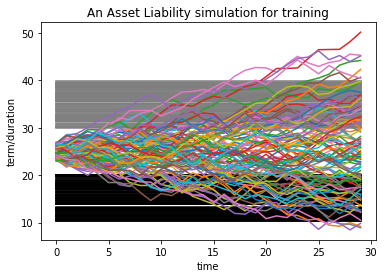

In [12]:
asset1term=training_simulation[:,0:100,0]
asset2term=training_simulation[:,0:100,1]
liabilities_duration=training_simulation[:,0:100,2]
plt.plot(asset1term,color ="black")
plt.plot(asset2term,color = "grey")
plt.plot(liabilities_duration)
plt.xlabel("time")
plt.ylabel("term/duration")
plt.title("An Asset Liability simulation for training")
plt.show

TASK 2: ALM DEEP REINFORCEMENT LEARNING 

In [44]:
#DEFINING REINFORCEMENT LEARNING AGENT FOR ALM 
from IPython.core.debugger import set_trace

class ALM_Agent(object):
    def __init__(self, time_steps, batch_size, features, nodes = [62,46,46,1], name='alm_model'):
        tf.reset_default_graph()
        self.batch_size = batch_size 
        self.alm_input = tf.placeholder(tf.float32, [time_steps, batch_size, features]) 

        self.asset1= self.alm_input[:,:,0]
        self.asset2= self.alm_input[:,:,1]
        self.liabilities= self.alm_input[:,:,2]

        alm_input_mod = tf.unstack(self.alm_input, axis=0)

        # Build the lstm
        lstm = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.LSTMCell(n) for n in nodes])

        self.strategy, state = tf.nn.static_rnn(lstm, alm_input_mod, initial_state=lstm.zero_state(batch_size, tf.float32), dtype=tf.float32)
        #self.strategy = tf.contrib.layers.fully_connected(inputs=alm_input_mod, num_outputs=1,activation_fn=tf.nn.relu)

        self.strategy_mod = tf.reshape(self.strategy, (time_steps, batch_size))

        self.asset1_weight=self.strategy_mod
        self.asset2_weight=tf.ones([time_steps, batch_size], dtype=tf.float32)-self.strategy_mod

        # dL = self.alm_input[1:,:,2] - self.alm_input[0:-1,:,2] 
        # liability_volatility = tf.math.reduce_sum(dL,axis=0)
        self.risk_margin = tf.math.multiply(tf.ones([time_steps, batch_size], dtype=tf.float32),1)
        #self.risk_margin = tf.ones([time_steps, batch_size], dtype=tf.float32)


        self.errors=tf.math.multiply( self.asset1_weight, self.asset1) + tf.math.multiply(self.asset2_weight, self.asset2) -  self.liabilities  -   self.risk_margin   #duration mismatch errors
        self.errors_squared = tf.square(self.errors)  #Sum square errors
        self.SSE = tf.reduce_sum(self.errors_squared,axis=0)      
        BATCH_SSE = tf.reduce_mean(self.SSE)

        self.train = tf.train.AdamOptimizer().minimize(BATCH_SSE) 
        #self.train = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(BATCH_SSE) #Synonymous with Stochastic Gradient descent 
        #self.train = tf.train.ProximalGradientDescentOptimizer(learning_rate=0.01).minimize(BATCH_SSE) #Synonymous with Stochastic Gradient descent 

        self.saver = tf.train.Saver()
        self.modelname = name
        
    def _execute_graph_batchwise(self, paths, sess, epochs=1, train_flag=False):
        sample_size = paths.shape[1]
        batch_size=self.batch_size
        idx = np.arange(sample_size)
        start = dt.datetime.now()
        for epoch in range(epochs):
            # Save the ALM mismatch errors for each batch      
            mismatch_errors = []
            strategies = []            
            if train_flag:
                np.random.shuffle(idx)
            for i in range(int(sample_size/batch_size)):
                indices = idx[i*batch_size : (i+1)*batch_size]
                batch = paths[:,indices,:]
                if train_flag:#runs the train, alm SSE and strategy using the inputs 
                    _, SSE, strategy = sess.run([self.train, self.SSE, self.strategy], {self.alm_input: batch})
                else:
                    SSE, strategy = sess.run([self.SSE, self.strategy], {self.alm_input: batch})
                mismatch_errors.append(SSE)
                strategies.append(strategy)

            EPOCH_SSE = np.mean(np.concatenate(mismatch_errors))
            #set_trace()
            if train_flag:
                #if epoch % 10 == 0:
                if epoch % 1 == 0:
                    print('Time elapsed:', dt.datetime.now()-start)
                    print('Epoch', epoch, 'SSE', EPOCH_SSE)
                    #Saving the model
                    self.saver.save(sess, "alm_model9.ckpt")
        self.saver.save(sess, "alm_model9.ckpt")
        return EPOCH_SSE, np.concatenate(mismatch_errors), np.concatenate(strategies,axis=1)
    
    def training(self, paths, epochs, session, init=True):   #DEFINE THE TRAINING FUNCTION 
        if init:
            sess.run(tf.global_variables_initializer())
        self._execute_graph_batchwise(paths, session, epochs, train_flag=True)
        
    def predict(self, paths, session):  #DEFINE THE PREDICTION FUNCTION 
        return self._execute_graph_batchwise(paths,session, 1, train_flag=False)

    def restore(self, session, checkpoint):
        self.saver.restore(session, checkpoint)

In [45]:
#CREATING AN AGENT OBJECT 
batch_size = 1000
features = 3
data = training_simulation

model_9 = ALM_Agent(data.shape[0], batch_size, features, name='alm_model9')

In [46]:
#EXECUTING AGENT EXPERIMENTS AND REINFORCEMENT LEARNING TRAINING (10-100 epochs)
epoch=50
start = dt.datetime.now()
with tf.Session() as sess:
    # Train Model
    model_9.training(data, epoch, sess)
print('Training finished, Time elapsed:', dt.datetime.now()-start)

Time elapsed: 0:00:36.171840
Epoch 0 SSE 1019.80536
Time elapsed: 0:01:05.762928
Epoch 1 SSE 293.40347
Time elapsed: 0:01:36.535662
Epoch 2 SSE 181.9681
Time elapsed: 0:02:08.067388
Epoch 3 SSE 130.92596
Time elapsed: 0:02:39.806188
Epoch 4 SSE 110.78406
Time elapsed: 0:03:11.918748
Epoch 5 SSE 102.74999
Time elapsed: 0:03:44.112248
Epoch 6 SSE 99.14744
Time elapsed: 0:04:17.453407
Epoch 7 SSE 97.21903
Time elapsed: 0:04:49.938543
Epoch 8 SSE 95.55204
Time elapsed: 0:05:22.762722
Epoch 9 SSE 95.88374
Time elapsed: 0:05:56.611390
Epoch 10 SSE 94.12382
Time elapsed: 0:06:30.176078
Epoch 11 SSE 93.6822
Time elapsed: 0:07:05.016001
Epoch 12 SSE 93.69755
Time elapsed: 0:07:39.911497
Epoch 13 SSE 93.38039
Time elapsed: 0:08:14.895617
Epoch 14 SSE 93.17097
Time elapsed: 0:08:49.838616
Epoch 15 SSE 92.79767
Time elapsed: 0:09:24.761624
Epoch 16 SSE 93.67844
Time elapsed: 0:09:59.764268
Epoch 17 SSE 92.54933
Time elapsed: 0:11:02.088658
Epoch 18 SSE 92.24978
Time elapsed: 0:23:18.160408
Epoch 1

TESTING ON UNSEEN TEST DATA

In [47]:
#TEST DATA PERFORMANCE 
test_data=generate_multiple_simulations(steps=30,number_simulations=1000,max_change=2) #why same size as training data**
#test_data2=generate_multiple_simulations(steps=100,number_simulations=10000,max_change=1,duration_start=25) #increased liability step size to test for adaptability to volatility
test_data.shape


(30, 1000, 3)

In [48]:
#TEST DATA PERFORMANCE
#Analysing results
with tf.Session() as sess:
    model_9.restore(sess, 'alm_model9.ckpt')
    #Using the model_1 trained in the section above
    test_results = model_9.predict(test_data, sess)

INFO:tensorflow:Restoring parameters from alm_model9.ckpt


In [49]:
#SSE 
print("SEE mean:",np.mean(test_results[1]))
print("SEE Lower Bound",np.mean(test_results[1])-2*np.std(test_results[1]))
print("SEE Upper Bound",np.mean(test_results[1])+2*np.std(test_results[1]))

SEE mean: 95.01517
SEE Lower Bound -627.7597351074219
SEE Upper Bound 817.7900695800781


<function matplotlib.pyplot.show(close=None, block=None)>

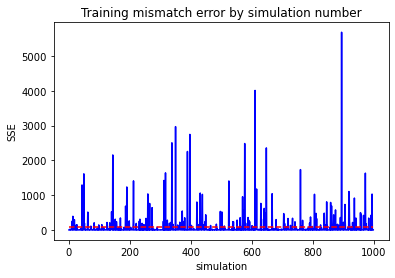

In [50]:
#MISMATCH ERRORS
plt.plot(test_results[1],color ="blue")
plt.plot(np.full((len(test_results[1]),),test_results[0]),color ="red",linestyle='--')
plt.xlabel("simulation")
plt.ylabel("SSE")
plt.title('Training mismatch error by simulation number')
plt.show

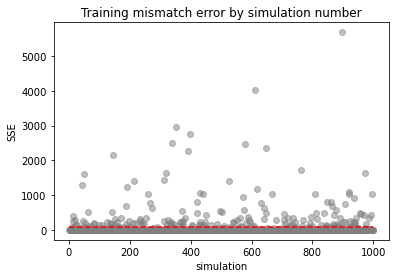

In [51]:
x=np.arange(len(test_results[1]))+1
y=test_results[1]
plt.scatter(x, y, c="grey", alpha=0.5)
plt.plot(np.full((len(test_results[1]),),test_results[0]),color ="red",linestyle='--')
plt.xlabel("simulation")
plt.ylabel("SSE")
plt.title('Training mismatch error by simulation number')
plt.show()

In [52]:
np.argwhere(test_results[1]>1000)

array([[ 43],
       [ 49],
       [144],
       [190],
       [212],
       [259],
       [312],
       [317],
       [338],
       [350],
       [389],
       [397],
       [431],
       [438],
       [525],
       [577],
       [611],
       [616],
       [648],
       [667],
       [760],
       [806],
       [895],
       [919],
       [920],
       [973],
       [995]])

In [53]:
#TEST DATA PERFORMANCE (VISUALISATION)
weights_predictions_test_interim = test_results[2]
weights_predictions_test = np.reshape(weights_predictions_test_interim,(weights_predictions_test_interim.shape[0],weights_predictions_test_interim.shape[1]))
weights_predictions_test

array([[0.6002708 , 0.60033107, 0.26229587, ..., 0.5186272 , 0.4777123 ,
        0.42132887],
       [0.53538716, 0.5206028 , 0.3765298 , ..., 0.5253525 , 0.5134626 ,
        0.43108064],
       [0.57704586, 0.57020265, 0.36553493, ..., 0.59133095, 0.53250736,
        0.341413  ],
       ...,
       [0.41460428, 0.15415765, 0.4452819 , ..., 0.724934  , 0.17829232,
        0.57530046],
       [0.5116951 , 0.23165485, 0.35084248, ..., 0.676892  , 0.10617723,
        0.7059903 ],
       [0.37696242, 0.21615577, 0.31434473, ..., 0.65548027, 0.08098613,
        0.74641407]], dtype=float32)

In [54]:
#Weights range between 0 and 1
np.min(weights_predictions_test),np.max(weights_predictions_test)

(2.1133485e-05, 0.9998857)

In [55]:
#Allocations that would be done in practice 
#Analytical solutions with visibility up to time t
analytical_weights_test=np.full((test_data.shape[0],test_data.shape[1]),fill_value=0.0)

analytical_lag = 6
original_range=np.arange(test_data.shape[0])
new_range=np.array([])
i_mod_step_list=np.array([])
for i in original_range:
    if i%analytical_lag==0:
        i_mod = i
        i_mod_step_list=np.append(i_mod_step_list,i_mod)
    else:
        i_mod = i_mod_step_list[-1]
    new_range = np.append(new_range,i_mod)

new_range=new_range.astype(int)

for i in np.arange(len(new_range)):
    for j in np.arange(test_data.shape[1]):
        data_point_assets=test_data[new_range[i]][j]
        #data_point_liabilities=test_data[i][j]
        #print(data_point)
        t1=data_point_assets[0]
        t2=data_point_assets[1]
        tl=data_point_assets[2]
        analytical_weight= zc_immuniser(t1,t2,tl)[3]
        #print(analytical_weight)
        analytical_weights_test[i,j] = analytical_weight
analytical_weights_test.shape, analytical_weights_test

((30, 1000),
 array([[0.66982145, 0.6358186 , 0.32787636, ..., 0.55998098, 0.52249882,
         0.49124443],
        [0.66982145, 0.6358186 , 0.32787636, ..., 0.55998098, 0.52249882,
         0.49124443],
        [0.66982145, 0.6358186 , 0.32787636, ..., 0.55998098, 0.52249882,
         0.49124443],
        ...,
        [0.61815865, 0.36585387, 0.44312852, ..., 0.64707514, 0.22258884,
         0.69241355],
        [0.61815865, 0.36585387, 0.44312852, ..., 0.64707514, 0.22258884,
         0.69241355],
        [0.61815865, 0.36585387, 0.44312852, ..., 0.64707514, 0.22258884,
         0.69241355]]))

In [56]:
#Allocations that would be done with perfect information(Perfect allocations)
#Analytical solutions with visibility up to time t
perfect_weights_test=np.full((test_data.shape[0],test_data.shape[1]),fill_value=0.0)
for i in np.arange(test_data.shape[0]):
    for j in np.arange(test_data.shape[1]):
        data_point_assets=test_data[i][j]
        data_point_liabilities=test_data[i][j]
        #print(data_point)
        t1=data_point_assets[0]
        t2=data_point_assets[1]
        tl=data_point_liabilities[2]
        perfect_weight= zc_immuniser(t1,t2,tl)[3]
        #print(analytical_weight)
        perfect_weights_test[i,j] = perfect_weight
perfect_weights_test.shape, perfect_weights_test

((30, 1000),
 array([[0.66982145, 0.6358186 , 0.32787636, ..., 0.55998098, 0.52249882,
         0.49124443],
        [0.6000056 , 0.56459468, 0.43523663, ..., 0.56307253, 0.55136185,
         0.5073053 ],
        [0.6377955 , 0.60921719, 0.423212  , ..., 0.62955571, 0.56877026,
         0.41468483],
        ...,
        [0.48404692, 0.19519319, 0.50446329, ..., 0.76071312, 0.20913839,
         0.65405809],
        [0.5725963 , 0.26515915, 0.41199814, ..., 0.7130539 , 0.14787583,
         0.78697975],
        [0.44711885, 0.25156867, 0.37226775, ..., 0.69037431, 0.11995852,
         0.8200094 ]]))

In [58]:
#COMPARISON
comparison_time_point = -1 
analytical_weights_final = analytical_weights_test[comparison_time_point,:]
perfect_weights_final = perfect_weights_test[comparison_time_point,:]
predicted_weights_final = weights_predictions_test[comparison_time_point,:]

predicted_less_perfect = predicted_weights_final - perfect_weights_final
analytical_less_perfect = analytical_weights_final - perfect_weights_final

predicted_weights_diff = np.sum(np.abs(predicted_less_perfect))
analytical_weights_diff = np.sum(np.abs(analytical_less_perfect))

#predicted_weights_vs_analytical=np.abs(predicted_weights_final - perfect_weights_final)/np.abs(analytical_weights_final - perfect_weights_final)
#predicted_weights_vs_analytical

In [59]:
predicted_weights_diff,analytical_weights_diff

(33.166445591167914, 77.46754209122417)

<function matplotlib.pyplot.show(close=None, block=None)>

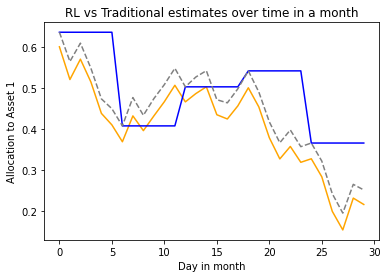

In [60]:
#TEST DATA PERFORMANCE (VISUALISATION)
#TRAINING DATA PERFORMANCE
test_index = 1
plt.plot(weights_predictions_test[:,test_index],color = "orange")
plt.plot(analytical_weights_test[:,test_index],color = "blue")
plt.plot(perfect_weights_test[:,test_index],color = "grey", linestyle='--')
#legend 
#plt.ylim(0,1.1)
plt.xlabel("Day in month")
plt.ylabel("Allocation to Asset 1")
#plt.ylim(0,1.1)
plt.title("RL vs Traditional estimates over time in a month")
plt.show

#3,4,6

<function matplotlib.pyplot.show(close=None, block=None)>

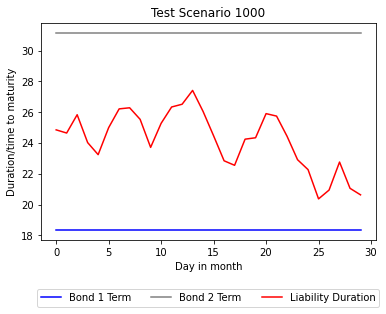

In [74]:
a1_vis = test_data[:,test_index,0]
a2_vis = test_data[:,test_index,1]
l_vis = test_data[:,test_index,2]
plt.plot(a1_vis,color = "blue",label = "Bond 1 Term")
plt.plot(a2_vis,color = "grey", label = "Bond 2 Term")
plt.plot(l_vis,color = "red", label = "Liability Duration")
plt.xlabel("Day in month")
plt.ylabel("Duration/time to maturity")
plt.legend(loc="upper center",bbox_to_anchor=(0.5, -0.2),ncol = 3)

plt.title(f"Test Scenario {test_index+1}")
plt.show

Diff Mean: 0.6491184379738089 Diff Std: 0.4607704359445633


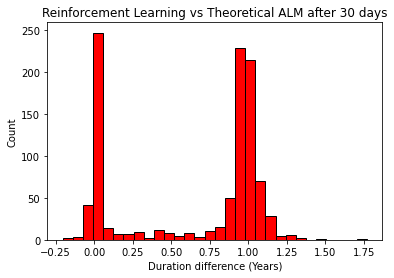

In [85]:
#REINFORCEMENT LEARNING DURATION VS THEORETICAL DURATION 
comparison_time_point = 29
duration_diff_agg=[]
for test_index in np.arange(test_data.shape[1]):
    test_asset_duration=weights_predictions_test[comparison_time_point,test_index]*test_data[comparison_time_point,test_index,0] + (1-weights_predictions_test[comparison_time_point,test_index])*test_data[comparison_time_point,test_index,1]
    test_asset_duration_perfect=perfect_weights_test[comparison_time_point,test_index]*test_data[comparison_time_point,test_index,0] + (1-perfect_weights_test[comparison_time_point,test_index])*test_data[comparison_time_point,test_index,1]
    duration_diff=(test_asset_duration-test_asset_duration_perfect)#/test_asset_duration_analytical
    #duration_diff_abs=np.abs(duration_diff)
    #duration_diff_mean=np.mean(duration_diff_abs)
    duration_diff_agg.append(duration_diff)
print("Diff Mean:", np.mean(duration_diff_agg),"Diff Std:",np.std(duration_diff_agg))
plt.xlabel("Duration difference (Years)")
plt.ylabel("Count")
#plt.ylim(0,1.1)
plt.title(f"Reinforcement Learning vs Theoretical ALM after {comparison_time_point+1} days")
plt.hist(duration_diff_agg,density=0,bins=30,color="red",ec="black")
plt.savefig('output/rq3_1.png',dpi=300, bbox_inches="tight")

In [91]:
duration_diff_agg_np=np.array(duration_diff_agg)
len(duration_diff_agg_np[np.argwhere(duration_diff_agg_np<-0.01)])/len(duration_diff_agg_np) #Proportion under 0.

0.043

In [92]:
# #TRADITIONAL ALM DURATION VS THEORETICAL ALM DURATION
# #comparison_time_point = 28
# duration_diff_agg=[]
# for test_index in np.arange(test_data.shape[1]):
#     test_asset_duration_analytical=analytical_weights_test[comparison_time_point,test_index]*test_data[comparison_time_point,test_index,0] + (1-analytical_weights_test[comparison_time_point,test_index])*test_data[comparison_time_point,test_index,1]
#     test_asset_duration_perfect=perfect_weights_test[comparison_time_point,test_index]*test_data[comparison_time_point,test_index,0] + (1-perfect_weights_test[comparison_time_point,test_index])*test_data[comparison_time_point,test_index,1]
#     duration_diff=(test_asset_duration_analytical-test_asset_duration_perfect)#/test_asset_duration_analytical
#     #duration_diff_abs=np.abs(duration_diff)
#     #duration_diff_mean=np.mean(duration_diff_abs)
#     duration_diff_agg.append(duration_diff)
# print("Diff Mean:", np.mean(duration_diff_agg),"Diff Std:",np.std(duration_diff_agg))
# plt.xlabel("Duration difference(Years)")
# plt.ylabel("Count")
# #plt.ylim(0,1.1)
# plt.title(f"Reinforcement Learning vs Theoretical ALM after {comparison_time_point+1} days")
# plt.hist(duration_diff_agg,density=0,bins=30,color="red",ec="black")


In [67]:
# #CUMULATIVE REINFORCEMENT LEARNING DURATION VS THEORETICAL DURATION 
# #comparison_time_point = 28

# def rl_vs_theoretical_comp(comparison_time_point):
#     duration_diff_agg=[]
#     for test_index in np.arange(test_data.shape[1]):
#         test_asset_duration=weights_predictions_test[comparison_time_point,test_index]*test_data[comparison_time_point,test_index,0] + (1-weights_predictions_test[comparison_time_point,test_index])*test_data[comparison_time_point,test_index,1]
#         test_asset_duration_perfect=perfect_weights_test[comparison_time_point,test_index]*test_data[comparison_time_point,test_index,0] + (1-perfect_weights_test[comparison_time_point,test_index])*test_data[comparison_time_point,test_index,1]
#         duration_diff=np.abs(test_asset_duration-test_asset_duration_perfect)
   
#         duration_diff_agg.append(duration_diff)

#     mean_duration_diff=np.mean(duration_diff_agg)
#     std_duration_diff=np.std(duration_diff_agg)

#     return np.array([mean_duration_diff,std_duration_diff])

# #rl_vs_theoretical_comp(28)


# rl_performances = []
# for time_point in np.arange(test_data.shape[0]):
#     ith_mean=rl_vs_theoretical_comp(time_point)[0]
#     rl_performances = np.append(rl_performances,ith_mean)

# # plt.plot(rl_performances,color = "orange")
# # plt.title("Relative Aggregate RL performance")
